# Defining a final DataSet

## Goal:
Recreate the final_dataset.ipynb

## Context:
Recreate the final_dataset, but each student will be considered as n-students where n is the number of semesters coursed. As an example, consider the student with ID 42. This student has been in the university for six semesters.
We will consider student 42 as six students: Student 42 from 1st semester, student 42 from 2nd semester, student 42 from 3rd semester, ... and student 42 from 6th semester.

This will allow the model to capture the behaviour of both dropout and non-dropout students in the early stages of their academic lives.
 

### Academic background
- **colegio**
- **puntaje icfes**
- **edad ingreso**
- **icfes puntaje especifico**
- **especialidad colegio icfes**
- **carrera matriculada**
- **Facultad**
- **genero**

### Academic performance
- **semestres cursados a la fecha** DONE
- **promedio academico a la fecha** DONE
- **promedio ultimo semestre**
- **Materias perdidas** DONE
- **Creditos cursados** DONE

All the features regarding academic performance will be affected by this approach!

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from datetime import datetime
import math
pd.set_option("display.max_columns", None)

We will start from two known files:
1. complete_student_performance
2. gpas_raw

These two files were originated from the final_dataset notebook. The first one has info for every subject that each student has coursed. The second one contains the GPAs for all students for each semester in a tidy format.

In [2]:
# Select the files
complete_student_performance_file = '../../data/processed/complete_student_performance.csv'
gpas_raw = '../../data/processed/gpas_raw.csv'

gpas_raw_df = pd.read_csv(gpas_raw, index_col=0).reset_index()
student_performance = pd.read_csv(complete_student_performance_file, index_col=0)

The following function is already known from other notebooks and helps convert columns data types.

We will use this function to adjust the columns data types for the student_performance DataFrame:

In [3]:
def change_type(df, cols, as_type):
    ''' 
    Takes a DataFrame and a list of columns and transform those columns to the selected format.
              
        Parameters
        ----------
        df: pandas.core.frame.DataFrame
            A pandas DataFrame where the columns will be converted into the desired format.
            
        cols: list
            A list with the name of the columns that will be converted into the desired format.
            
        as_type: {'str', 'float', 'int'}
            A list with the name of the columns that will be converted into the desired format.
            
        Returns
        -------
        dataframe: pandas.core.frame.DataFrame
            A DataFrame with the selected columsn converted into the desired format.
    ''' 
    if (as_type == 'str') or (as_type == 'int'):
        for col in cols:
            try:
                df[col] = df[col].astype(as_type)
            except: pass
        return df
    else:
        for col in cols:
            try:
                df[col] = df[col].str.replace(',','.')
                df[col] = df[col].astype('float64')
            except: pass
        return df

In [4]:
cat_cols = ['PERIODO_COHORTE', 'PERIODO_ACADEMICO', 'CODIGO', 'COD_MAT']
num_cols = ['NOTA_DEF']

student_performance = change_type(student_performance, cat_cols, 'str')
student_performance = change_type(student_performance, num_cols, 'float')


In [5]:
student_performance.head()

,PERIODO_COHORTE,PERIODO_ACADEMICO,CODIGO,COD_MAT,NOMBRE_MAT,NOTA_DEF,ESTADO,COD_DOCENTE,FACULTAD,NOMBRE_PROGRAMA,INTRODUCCION,NUM_CREDITOS
0,201210,201210,11312001,11305,EXP. ORAL ESCRITA,3.5,APROBADA,622.0,FACULTAD DE CIENCIAS ADMINISTRATIVAS Y CONTABLES,ADMINISTRACIÓN DE EMPRESAS,NO,2.0
1,201210,201210,11312001,11312,INICIATIVA EMPRES,4.0,APROBADA,1329.0,NaN,NaN,NaN,NaN
2,201210,201210,11312001,11310,MICROECONOMÍA,3.6,APROBADA,NaN,FACULTAD DE CIENCIAS ADMINISTRATIVAS Y CONTABLES,ADMINISTRACIÓN DE EMPRESAS,NO,3.0
3,201210,201210,11312001,11315,INFORMÁTICA BÁSICA,3.3,APROBADA,4016.0,NaN,NaN,NaN,NaN
4,201210,201210,11312001,11303,INTROD. AL PROGRAMA,3.8,APROBADA,1329.0,FACULTAD DE CIENCIAS ADMINISTRATIVAS Y CONTABLES,ADMINISTRACIÓN DE EMPRESAS,SI,2.0


Let's create a new column boolean for the student_performance DataFrame that indicates whether a subject was or was not failed. Then, we can group that DataFrame by student's ID and period, adding the values of the new column:

In [6]:
student_performance['failed_flag'] = [True if i < 3 else False for i in student_performance['NOTA_DEF']]
failed_subjects_df = student_performance.groupby(['CODIGO','PERIODO_ACADEMICO'])[['failed_flag']].sum().reset_index()
failed_subjects_df.head()

,CODIGO,PERIODO_ACADEMICO,failed_flag
0,11312001,201210,0.0
1,11312001,201220,0.0
2,11312001,201310,0.0
3,11312001,201320,0.0
4,11312001,201410,1.0


Let's now create a copy of the same dataset but now the failed_flag column will be cumulative for each student:

In [7]:
def get_cumulative_failed(df):
    df['cumulative_failed'] = 0
    
    init_cumulative = 0
    codigo = 'sw'
    for index, row in df.iterrows():
        if codigo != df.loc[index, 'CODIGO']:
            codigo = df.loc[index, 'CODIGO']
            init_cumulative = 0
            
            df.loc[index, 'cumulative_failed'] = init_cumulative + df.loc[index, 'failed_flag']
            init_cumulative = df.loc[index, 'cumulative_failed']
        else:
            df.loc[index, 'cumulative_failed'] = init_cumulative + row['failed_flag'] 
            init_cumulative = df.loc[index, 'cumulative_failed']
            
    return df

failed_subjects_df = get_cumulative_failed(failed_subjects_df)
failed_subjects_df.head()

,CODIGO,PERIODO_ACADEMICO,failed_flag,cumulative_failed
0,11312001,201210,0.0,0.0
1,11312001,201220,0.0,0.0
2,11312001,201310,0.0,0.0
3,11312001,201320,0.0,0.0
4,11312001,201410,1.0,1.0


Let's do a similar process with a dataset stored in **'../../data/processed/gpas_grouped_by_student.csv'**. It's like the previous one but this one contains data about number of credits and GPAs per semester. Here we will try to get the cumulative number of credits coursed and the cumulative GPA over the semesters:

In [8]:
grouped_df = pd.read_csv('../../data/processed/gpas_grouped_by_student.csv', index_col=0)

def get_cumulative_credits(df):
    df['cumulative_credits'] = 0
    df['cumulative_gpa'] = 0
    
    init_cumulative = 0
    init_gpa = 0
    codigo = 'sw'
    
    for index, row in df.iterrows():
        if codigo != df.loc[index, 'CODIGO']:
            codigo = df.loc[index, 'CODIGO']
            init_cumulative = 0
            init_gpa = 0
            
            df.loc[index, 'cumulative_credits'] = init_cumulative + df.loc[index, 'NUM_CREDITOS']
            df.loc[index, 'cumulative_gpa'] = init_gpa + df.loc[index, 'GPA']
            
            init_cumulative = df.loc[index, 'cumulative_credits']
            init_gpa = df.loc[index, 'cumulative_gpa']
            
        else:
            df.loc[index, 'cumulative_credits'] = init_cumulative + row['NUM_CREDITOS']
            df.loc[index, 'cumulative_gpa'] = init_gpa + row['GPA']
            
            
            init_cumulative = df.loc[index, 'cumulative_credits']
            init_gpa = df.loc[index, 'cumulative_gpa']
            
    df['real_cumulative_gpa'] = df['cumulative_gpa']/df['cumulative_credits']
            
    return df

num_credits_df = get_cumulative_credits(grouped_df)

In [9]:
num_credits_df.head(5)

,CODIGO,PERIODO_ACADEMICO,NUM_CREDITOS,GPA,real_GPA,cumulative_credits,cumulative_gpa,real_cumulative_gpa
0,11312001,201210,15.0,53.7,3.58,15.0,53.7,3.580000
1,11312001,201220,12.0,47.7,3.98,27.0,101.4,3.755556
2,11312001,201310,10.0,34.8,3.48,37.0,136.2,3.681081
3,11312001,201320,16.0,56.4,3.53,53.0,192.6,3.633962
4,11312001,201410,14.0,46.1,3.29,67.0,238.7,3.562687


These dataframes will serve us for a later merge on our tidy dataset. So let's leave them here for now.
We can now focus on a new dataset called extended_gpas_raw.

This extended_gpas_raw dataset was generated by the **expand_gpas** notebook and represented each student as n different students where n is the number of semesters coursed as stated in the context.

**IMPORTANT**
1. The details of how this dataset was constructed are in the same notebook.
2. Most of the commented markdowns are the same as the final_dataset notebook since the processes are the same.

In [10]:
extended_gpas_raw = pd.read_csv('../../data/processed/extended_gpas_raw.xlsx', index_col = 0)
extended_gpas_raw = extended_gpas_raw.dropna(subset = ['currrent_semester'])
extended_gpas_raw.head()

,201210,201211,201220,201310,201311,201320,201410,201411,201420,201421,201510,201511,201520,201521,201610,201611,201620,201621,201710,201711,201720,201721,201810,201811,201820,201821,201910,201911,201920,201921,202010,202011,202020,202021,202110,CODIGO,currrent_semester
0,3.6,NaN,3.98,3.485,NaN,3.5,3.295,NaN,3.87,NaN,3.01,NaN,3.27,NaN,3.505,NaN,2.58,NaN,4.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11312001,201710.0
0,3.6,NaN,3.98,3.485,NaN,3.5,3.295,NaN,3.87,NaN,3.01,NaN,3.27,NaN,3.505,NaN,2.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11312001,201620.0
0,3.6,NaN,3.98,3.485,NaN,3.5,3.295,NaN,3.87,NaN,3.01,NaN,3.27,NaN,3.505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11312001,201610.0
0,3.6,NaN,3.98,3.485,NaN,3.5,3.295,NaN,3.87,NaN,3.01,NaN,3.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11312001,201520.0
0,3.6,NaN,3.98,3.485,NaN,3.5,3.295,NaN,3.87,NaN,3.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11312001,201510.0


**It is not ideal to have one column for each period, but we can still get useful info from this table like the number of semesters and global GPA (we could have gotten this from the table before pivoting but let's do it from here).**

**The steps for achieving this are the following:**

**- Get the number of semesters coursed as the count of semesters where the GPA > 0.0**
- Calculate the credits coursed with a table called "num_creds"
- Calculate the raw GPA with a table called "gpas_raw"
- Get the real GPA dividing the raw GPA by the gpas_raw
- Get the number of failed subjects**

In [11]:
def get_number_semesters(df):
    df['n_semesters']= 0
    
    for index, row in df.iterrows():
        for column in df.columns[0:-1]:
            if row[column] > 0:
                df.loc[index,'n_semesters'] = df.loc[index,'n_semesters'] + 1
                
    df['n_semesters'] = [i-2 for i in df['n_semesters']]
    try:
        df = df.drop('index', axis = 1)
    except:
        pass
    
    return df

gpas = extended_gpas_raw.reset_index().copy()
gpas_n_semester = get_number_semesters(gpas)
gpas_n_semester.head()

,201210,201211,201220,201310,201311,201320,201410,201411,201420,201421,201510,201511,201520,201521,201610,201611,201620,201621,201710,201711,201720,201721,201810,201811,201820,201821,201910,201911,201920,201921,202010,202011,202020,202021,202110,CODIGO,currrent_semester,n_semesters
0,3.6,NaN,3.98,3.485,NaN,3.5,3.295,NaN,3.87,NaN,3.01,NaN,3.27,NaN,3.505,NaN,2.58,NaN,4.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11312001,201710.0,11
1,3.6,NaN,3.98,3.485,NaN,3.5,3.295,NaN,3.87,NaN,3.01,NaN,3.27,NaN,3.505,NaN,2.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11312001,201620.0,10
2,3.6,NaN,3.98,3.485,NaN,3.5,3.295,NaN,3.87,NaN,3.01,NaN,3.27,NaN,3.505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11312001,201610.0,9
3,3.6,NaN,3.98,3.485,NaN,3.5,3.295,NaN,3.87,NaN,3.01,NaN,3.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11312001,201520.0,8
4,3.6,NaN,3.98,3.485,NaN,3.5,3.295,NaN,3.87,NaN,3.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11312001,201510.0,7


All columns must have the correct data type. let's use our previously defined function again for this: 

In [12]:
gpas_n_semester['currrent_semester'] = gpas_n_semester['currrent_semester'].astype('int')
new_cat_cols = ['currrent_semester', 'CODIGO']

gpas_n_semester = change_type(gpas_n_semester, cat_cols, 'int64')

We can now drop all columns for specific semesters since we already extracted the needed data from those columns:

In [13]:
gpas_n_semester_lite = gpas_n_semester.iloc[:, 35:]
gpas_n_semester_lite.head()

,CODIGO,currrent_semester,n_semesters
0,11312001,201710,11
1,11312001,201620,10
2,11312001,201610,9
3,11312001,201520,8
4,11312001,201510,7


Let's use our num_credits_df and failed_subjects_df tables.

With a left join the data from those tables can be included into the gpas_n_semester_lite table:

1- Merge with num_credits_df to get cumulative_credits and real_cumulative_gpa

In [14]:
left_table = num_credits_df[["CODIGO", 'PERIODO_ACADEMICO', 'cumulative_credits', 'real_cumulative_gpa']]

gpas_merge_1 = pd.merge(gpas_n_semester_lite, left_table,\
                how="left", left_on = ["CODIGO", 'currrent_semester'], right_on = ["CODIGO", 'PERIODO_ACADEMICO']) 

gpas_merge_1 = gpas_merge_1.drop('currrent_semester', axis = 1)
gpas_merge_1.head()

,CODIGO,n_semesters,PERIODO_ACADEMICO,cumulative_credits,real_cumulative_gpa
0,11312001,11,201710,150.0,3.504000
1,11312001,10,201620,136.0,3.395588
2,11312001,9,201610,123.0,3.481301
3,11312001,8,201520,112.0,3.466964
4,11312001,7,201510,98.0,3.467347


2- Merge with failed_subjects_df to get cumulative_failed

In [15]:
left_table_2 = failed_subjects_df[["CODIGO", 'PERIODO_ACADEMICO', 'cumulative_failed']]
left_table_2 = change_type(left_table_2.copy(), list(left_table.columns), 'int64')

gpas_merge_2 = pd.merge(gpas_merge_1, left_table_2,\
                how="left", left_on = ["CODIGO", 'PERIODO_ACADEMICO'], right_on = ["CODIGO", 'PERIODO_ACADEMICO'])
gpas_merge_2.head()

,CODIGO,n_semesters,PERIODO_ACADEMICO,cumulative_credits,real_cumulative_gpa,cumulative_failed
0,11312001,11,201710,150.0,3.504000,5.0
1,11312001,10,201620,136.0,3.395588,5.0
2,11312001,9,201610,123.0,3.481301,4.0
3,11312001,8,201520,112.0,3.466964,4.0
4,11312001,7,201510,98.0,3.467347,4.0


2- Merge with num_credits_df to get gpa_last_semester

In [16]:
left_table_3 = num_credits_df.copy()
left_table_3 = left_table_3[['CODIGO', 'PERIODO_ACADEMICO', 'real_GPA']]
left_table_3.columns = ['CODIGO', 'PERIODO_ACADEMICO', 'gpa_last_semester']

gpas_merge_3 = pd.merge(gpas_merge_2, left_table_3,\
                how="left", left_on = ['CODIGO', 'PERIODO_ACADEMICO'], right_on = ["CODIGO", 'PERIODO_ACADEMICO'])
gpas_merge_3.head()

,CODIGO,n_semesters,PERIODO_ACADEMICO,cumulative_credits,real_cumulative_gpa,cumulative_failed,gpa_last_semester
0,11312001,11,201710,150.0,3.504000,5.0,4.56
1,11312001,10,201620,136.0,3.395588,5.0,2.58
2,11312001,9,201610,123.0,3.481301,4.0,3.63
3,11312001,8,201520,112.0,3.466964,4.0,3.46
4,11312001,7,201510,98.0,3.467347,4.0,2.87


The academic background data can be now included using perfil_ingreso.csv:

In [17]:
perfil_file = '../../data/raw/perfil_ingreso.csv'
student_profile = pd.read_csv(perfil_file, delimiter=';', encoding='latin-1')
student_profile = change_type(student_profile, ['CODIGO'], 'int')
student_profile = student_profile.drop('PERIODO_COHORTE', axis = 1)

In [18]:
extended_with_profile = pd.merge(gpas_merge_3, student_profile, how="left", left_on = "CODIGO", right_on = "CODIGO")

mean_Age = np.mean(extended_with_profile['EDAD'])
extended_with_profile['EDAD'] = extended_with_profile['EDAD'].fillna(mean_Age)

extended_with_profile.head()

,CODIGO,n_semesters,PERIODO_ACADEMICO,cumulative_credits,real_cumulative_gpa,cumulative_failed,gpa_last_semester,GENERO,EDAD,COLEGIO_PROCEDENCIA,PUNT_TOTAL,PUNT_AREA,ES_DESERTOR
0,11312001,11,201710,150.0,3.504000,5.0,4.56,M,22.0,COL COOP COOSERVICIOS,438,49,NO
1,11312001,10,201620,136.0,3.395588,5.0,2.58,M,22.0,COL COOP COOSERVICIOS,438,49,NO
2,11312001,9,201610,123.0,3.481301,4.0,3.63,M,22.0,COL COOP COOSERVICIOS,438,49,NO
3,11312001,8,201520,112.0,3.466964,4.0,3.46,M,22.0,COL COOP COOSERVICIOS,438,49,NO
4,11312001,7,201510,98.0,3.467347,4.0,2.87,M,22.0,COL COOP COOSERVICIOS,438,49,NO


Now, we only need to add the faculty and name of the program.

The process of geting and cleaning this data is described in the final_dataset.ipynb notebbok:

In [19]:
complete_student_performance_file = '../../data/processed/complete_student_performance.csv'
complete_student_performance = pd.read_csv(complete_student_performance_file, index_col=0 )


cat_cols = ['PERIODO_COHORTE', 'PERIODO_ACADEMICO', 'CODIGO', 'COD_MAT']
num_cols = ['NOTA_DEF']

complete_student_performance = change_type(complete_student_performance, cat_cols, 'str')
complete_student_performance = change_type(complete_student_performance, num_cols, 'float')

complete_student_performance[['FACULTAD','NOMBRE_PROGRAMA']] = \
                    complete_student_performance[['FACULTAD','NOMBRE_PROGRAMA']].fillna('GENERAL')
complete_student_performance[['INTRODUCCION']] = complete_student_performance[['INTRODUCCION']].fillna('NO')
complete_student_performance[['NUM_CREDITOS']] = complete_student_performance[['NUM_CREDITOS']].fillna(2)
complete_student_performance[['COD_DOCENTE']] = complete_student_performance[['COD_DOCENTE']].fillna(-1)




program = complete_student_performance.copy()
program = program[program['INTRODUCCION']=='SI']
program = program.groupby(['CODIGO'])['FACULTAD','NOMBRE_PROGRAMA'].agg(lambda x:x.value_counts().index[0]).reset_index()
program['CODIGO'] = program['CODIGO'].astype('int64')

extended_with_program = pd.merge(extended_with_profile, program, how="left", left_on = "CODIGO", right_on = "CODIGO")
extended_with_program = extended_with_program.dropna()
extended_with_program.head()

,CODIGO,n_semesters,PERIODO_ACADEMICO,cumulative_credits,real_cumulative_gpa,cumulative_failed,gpa_last_semester,GENERO,EDAD,COLEGIO_PROCEDENCIA,PUNT_TOTAL,PUNT_AREA,ES_DESERTOR,FACULTAD,NOMBRE_PROGRAMA
0,11312001,11,201710,150.0,3.504000,5.0,4.56,M,22.0,COL COOP COOSERVICIOS,438,49,NO,FACULTAD DE CIENCIAS ADMINISTRATIVAS Y CONTABLES,ADMINISTRACIÓN DE EMPRESAS
1,11312001,10,201620,136.0,3.395588,5.0,2.58,M,22.0,COL COOP COOSERVICIOS,438,49,NO,FACULTAD DE CIENCIAS ADMINISTRATIVAS Y CONTABLES,ADMINISTRACIÓN DE EMPRESAS
2,11312001,9,201610,123.0,3.481301,4.0,3.63,M,22.0,COL COOP COOSERVICIOS,438,49,NO,FACULTAD DE CIENCIAS ADMINISTRATIVAS Y CONTABLES,ADMINISTRACIÓN DE EMPRESAS
3,11312001,8,201520,112.0,3.466964,4.0,3.46,M,22.0,COL COOP COOSERVICIOS,438,49,NO,FACULTAD DE CIENCIAS ADMINISTRATIVAS Y CONTABLES,ADMINISTRACIÓN DE EMPRESAS
4,11312001,7,201510,98.0,3.467347,4.0,2.87,M,22.0,COL COOP COOSERVICIOS,438,49,NO,FACULTAD DE CIENCIAS ADMINISTRATIVAS Y CONTABLES,ADMINISTRACIÓN DE EMPRESAS


### Can we consider all students?
No. Since we can not know if newer students will drop out in the future, let's check the semester in which the newest dropout student was inscribed: 

In [20]:
perfil_file = '../../data/raw/perfil_ingreso.csv'
student_profile = pd.read_csv(perfil_file, delimiter=';', encoding='latin-1')
student_profile = change_type(student_profile, ['CODIGO'], 'str')

student_profile.head()

,PERIODO_COHORTE,CODIGO,GENERO,EDAD,COLEGIO_PROCEDENCIA,PUNT_TOTAL,PUNT_AREA,ES_DESERTOR
0,201210,11312001,M,22.0,COL COOP COOSERVICIOS,438,49,NO
1,201210,11312002,M,23.0,INSTITUTO DE EDUCACION MEDIA DIVERSIFICADA INE...,386,48,NO
2,201210,11312003,F,22.0,I.E. ANTONIO NARIÑO,460,51,NO
3,201210,11312004,F,25.0,I.E. LUIS HERNANDEZ VARGAS,41,42,NO
4,201210,11312005,M,25.0,IE TEC JOSE IGNACIO DE MARQUEZ,50,49,NO


In [21]:
list_periodos_desertores = list(student_profile[student_profile['ES_DESERTOR']=='SI']['PERIODO_COHORTE'].unique())
list_periodos_desertores.sort()
print(list_periodos_desertores)

[201210, 201220, 201310, 201320, 201410, 201420, 201510, 201520, 201610, 201620, 201710, 201720, 201810]


Now that we know that the newest dropout student was inscribed in 2018, let's keep only students inscribed until that date:

In [22]:
drop_newest_mask = [True if i in list_periodos_desertores else False for i in student_profile['PERIODO_COHORTE']]
student_profile['keep_student'] = drop_newest_mask
student_profile.head()

keep_students_list = list(student_profile[student_profile['keep_student'] == True]['CODIGO'])
keep_students_list = [int(i) for i in keep_students_list]

In [23]:
keep_older_mask = [True if i in keep_students_list else False for i in extended_with_program['CODIGO']]

In [24]:
extended_with_program = extended_with_program[keep_older_mask]

### Save our progress

In [25]:
extended_with_program.to_csv('../../data/processed/extended_dataset_final.csv')

In [26]:
extended_with_program = pd.read_csv('../../data/processed/extended_dataset_final.csv', index_col = 0)

A correlation analysis will be useful to identify highly correlated variables:

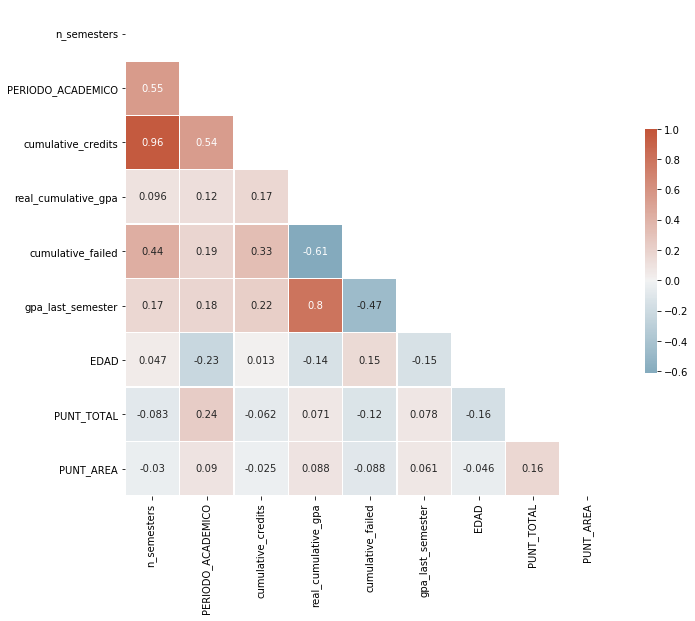

In [27]:
to_drop = ['FACULTAD', 'NOMBRE_PROGRAMA', 'GENERO', 'COLEGIO_PROCEDENCIA', 'ES_DESERTOR', 'CODIGO']
df_correlation = extended_with_program.drop(to_drop, axis = 1).corr()

mask = np.triu(np.ones_like(df_correlation, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_correlation, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

### Machine Learning Models

Let's try to predict dropout students from the extended dataset.
For this we will use the following models:
- Logistic Regression
- KNN
- Decision Tree
- Random Forest Classifier
- Ada Boost Classifier

In [28]:
# Create a dummy DataFrame
to_dummies = ['FACULTAD', 'NOMBRE_PROGRAMA', 'GENERO', 'COLEGIO_PROCEDENCIA', 'ES_DESERTOR']

gpas_dummy = pd.get_dummies(extended_with_program.drop(['CODIGO', 'PERIODO_ACADEMICO'], axis = 1), drop_first = True)

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
#Import ROC AUC score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

SEED = 1111
lr = LogisticRegression(random_state = SEED)
knn = KNN(n_neighbors = 6)
dt = DecisionTreeClassifier(criterion = 'gini', random_state = SEED, max_depth = round(len(gpas_dummy)**(1/2)))
rfc = RandomForestClassifier(n_estimators = 500 , min_samples_leaf = 0.12, random_state =SEED)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=100, random_state=1)
supvm = svm.SVC()

In [30]:
df_desertor = gpas_dummy[gpas_dummy['ES_DESERTOR_SI'] == 1]
df_no_desertor = gpas_dummy[gpas_dummy['ES_DESERTOR_SI'] == 0]

df_no_desertor = df_no_desertor.sample(n=len(df_desertor))

df_new = pd.concat([df_desertor, df_no_desertor])
df_new = df_new.sample(frac=1)

In [31]:
y1 = df_new['ES_DESERTOR_SI'].values
X1 = df_new.drop('ES_DESERTOR_SI', axis = 1).values
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.26, random_state = SEED, stratify = y1)

classifiers =[('Logistic Regression', lr), ('K Nearest Neighbors', knn),\
              ('Classification Tree', dt), ('Random Forest', rfc), ('Ada Boost', ada)]

vc = VotingClassifier(estimators = classifiers)

In [32]:
for clf_name, clf in classifiers:
    clf.fit(X1_train, y1_train)
    y1_pred = clf.predict(X1_test)
    
    y_pred_proba = clf.predict_proba(X1_test)[:,1]
    roc_score = roc_auc_score(y1_test, y_pred_proba)
    
    print('{:s} accuracy: {:.3f}'.format(clf_name, accuracy_score(y1_test, y1_pred)))
    print('{:s} ROC score: {:.3f}'.format(clf_name, roc_score))
    print('')
    
vc.fit(X1_train, y1_train)
y1_predVC = vc.predict(X1_test)
print('Voting Classifier accuracy: {:.3f}'.format(accuracy_score(y1_test, y1_predVC)))

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression accuracy: 0.825
Logistic Regression ROC score: 0.902

K Nearest Neighbors accuracy: 0.790
K Nearest Neighbors ROC score: 0.868

Classification Tree accuracy: 0.815
Classification Tree ROC score: 0.815

Random Forest accuracy: 0.787
Random Forest ROC score: 0.875

Ada Boost accuracy: 0.816
Ada Boost ROC score: 0.816



C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Voting Classifier accuracy: 0.830


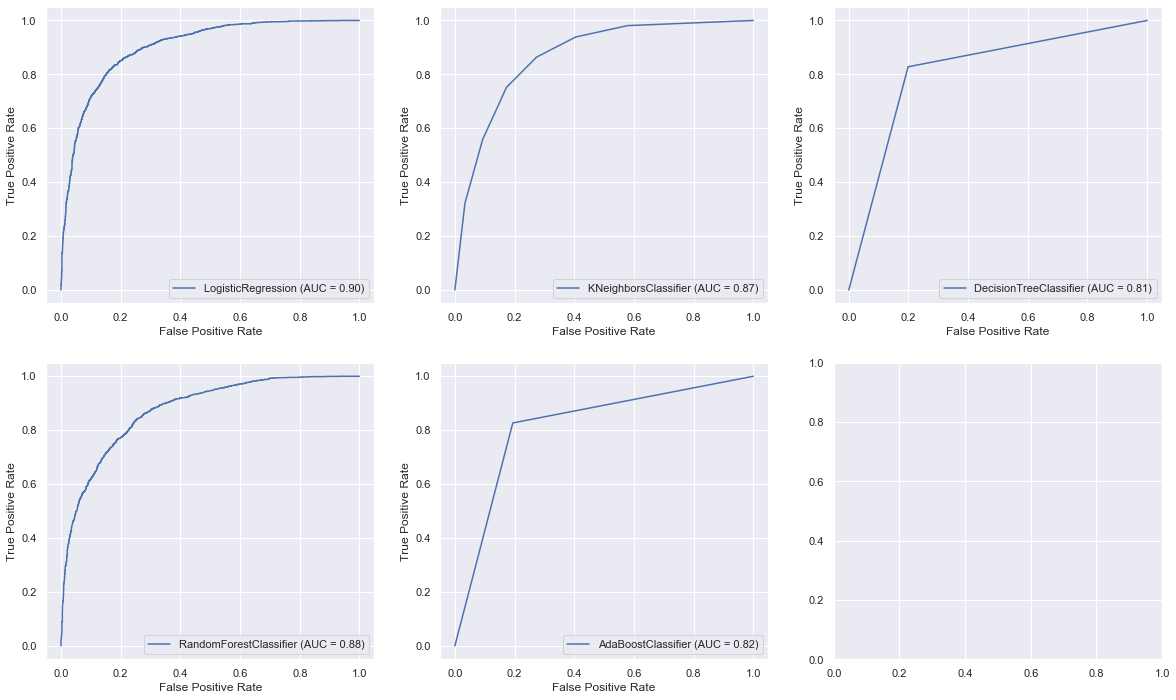

In [33]:
sns.set()
fig, axes = plt.subplots(2, 3, figsize = (20,12))
idxs = [axes[0,0], axes[0,1], axes[0,2], axes[1,0], axes[1,1]]

for (clf_name, clf), idx in zip(classifiers, idxs):
    #clf.fit(X1_train, y1_train)
    plot_roc_curve(clf, X1_test, y1_test, ax = idx)

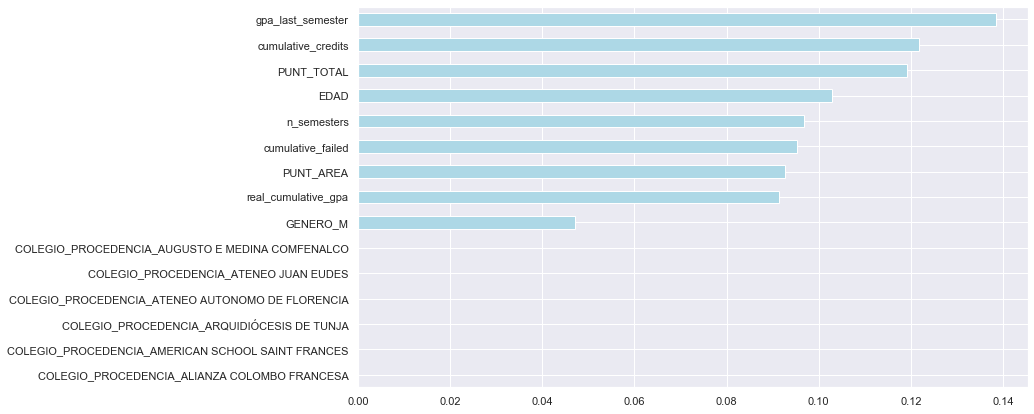

In [34]:
#Feature importance
fig, axes = plt.subplots(figsize= (12,7))
importances_rf =pd.Series(rfc.feature_importances_[0:15], index = df_new.drop\
                                          (['ES_DESERTOR_SI'], axis = 1).columns[0:15])
sorted_importances_rf = importances_rf.sort_values()
sns.set()
sorted_importances_rf.plot(kind='barh', color = 'lightblue')
plt.show()

In [38]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
print(len(max_depth))
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, cv = 3, n_iter = 20, n_jobs = -1,\
                               random_state=SEED)

rf_random.fit(X1_train, y1_train)

11


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(min_samples_leaf=0.12,
                                                    n_estimators=500,
                                                    random_state=1111),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 

In [39]:
print(rf_random.best_params_)
best_random_model = rf_random.best_estimator_
yrf_pred_random = best_random_model.predict(X1_test)
print('Random Forest accuracy: {:.3f}'.format(accuracy_score(y1_test, yrf_pred_random)))

{'n_estimators': 733, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}
Random Forest accuracy: 0.908


### Cross validation

Let's use cross validation to validate our models and see a most real performance:

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

rf_with_best_params = RandomForestClassifier(n_estimators = 733 , min_samples_split = 2, random_state =SEED,\
                    min_samples_leaf = 1, max_features = 'sqrt', max_depth = 70, bootstrap = False)

clf_names = ['Logistic Regression', 'K Nearest Neighbors', 'Classification Tree', 'Random Forest', 'Ada Boost']
clfs = [lr, knn, dt, rfc, ada]


cross_val_strategy = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

for classifier, classifier_name in zip(clfs, clf_names):
    scores = cross_val_score(classifier, X1_train, y1_train, cv = cross_val_strategy)
    
    mean_acc = np.mean(scores)
    std_acc = np.std(scores)
    
    print('{:s}  Mean accuracy: {:.3f}'.format(classifier_name, mean_acc))
    print('{:s}  Mean std: {:.3f}'.format(classifier_name, std_acc))
    print('')

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Logistic Regression  Mean accuracy: 0.817
Logistic Regression  Mean std: 0.009

K Nearest Neighbors  Mean accuracy: 0.774
K Nearest Neighbors  Mean std: 0.010

Classification Tree  Mean accuracy: 0.797
Classification Tree  Mean std: 0.012

Random Forest  Mean accuracy: 0.780
Random Forest  Mean std: 0.009

Ada Boost  Mean accuracy: 0.799
Ada Boost  Mean std: 0.009



### Save the model

In [114]:
import pickle

rf_model_file = '../../models/best_random_model.pkl'
with open(rf_model_file, 'wb') as file:
    pickle.dump(best_random_model, file)

### Load the model

In [115]:
with open(rf_model_file, 'rb') as file:
    best_random_model = pickle.load(file)
    
yrf_pred_random = best_random_model.predict(X1_test)
print('Random Forest accuracy: {:.3f}'.format(accuracy_score(y1_test, yrf_pred_random)))

Random Forest accuracy: 0.895


## Removing features

From the Feature importances plot previously generated, we can conclude that most important variables are:
- gpa_last_semester
- cumulative_credits
- PUNT_TOTAL
- EDAD
- n_semesters
- cumulative_failed
- PUNT_AREA
- real_cumulative_gpa
- GENERO

Let's try to fit a new model excluding all other variables

In [73]:
smaller_dataset = extended_with_program.drop(['CODIGO', 'PERIODO_ACADEMICO', 'COLEGIO_PROCEDENCIA',\
                                            'FACULTAD', 'NOMBRE_PROGRAMA'], axis = 1).copy()

gpas_dummy_smaller = pd.get_dummies(smaller_dataset, drop_first = True)

In [74]:
gpas_dummy_smaller.head()

,n_semesters,cumulative_credits,real_cumulative_gpa,cumulative_failed,gpa_last_semester,EDAD,PUNT_TOTAL,PUNT_AREA,GENERO_M,ES_DESERTOR_SI
0,11,150.0,3.504000,5.0,4.56,22.0,438,49,1,0
1,10,136.0,3.395588,5.0,2.58,22.0,438,49,1,0
2,9,123.0,3.481301,4.0,3.63,22.0,438,49,1,0
3,8,112.0,3.466964,4.0,3.46,22.0,438,49,1,0
4,7,98.0,3.467347,4.0,2.87,22.0,438,49,1,0


In [75]:
lr_s = LogisticRegression(random_state = SEED)
knn_s = KNN(n_neighbors = 6)
dt_s = DecisionTreeClassifier(criterion = 'gini', random_state = SEED, max_depth = round(len(gpas_dummy)**(1/2)))
rfc_s = RandomForestClassifier(n_estimators = 500 , min_samples_leaf = 0.12, random_state =SEED)
ada_s = AdaBoostClassifier(base_estimator=dt, n_estimators=100, random_state=1)
supvm_s = svm.SVC()
rf_with_best_params_s = RandomForestClassifier(n_estimators = 733 , min_samples_split = 2, random_state =SEED,\
                    min_samples_leaf = 1, max_features = 'sqrt', max_depth = 70, bootstrap = False)

In [76]:
df_desertor_s = gpas_dummy_smaller[gpas_dummy_smaller['ES_DESERTOR_SI'] == 1]
df_no_desertor_s = gpas_dummy_smaller[gpas_dummy_smaller['ES_DESERTOR_SI'] == 0]

df_no_desertor_s = df_no_desertor_s.sample(n=len(df_desertor_s))

df_new_s = pd.concat([df_desertor_s, df_no_desertor_s])
df_new_s = df_new_s.sample(frac=1)

In [77]:
y1_s = df_new_s['ES_DESERTOR_SI'].values
X1_s = df_new_s.drop('ES_DESERTOR_SI', axis = 1).values
X1_train_s, X1_test_s, y1_train_s, y1_test_s =\
        train_test_split(X1_s, y1_s, test_size = 0.26, random_state = SEED, stratify = y1_s)

In [78]:
clf_names = ['Logistic Regression', 'K Nearest Neighbors', 'Classification Tree', 'Random Forest', 'Ada Boost']
clfs_s = [lr_s, knn_s, dt_s, rfc_s, ada_s]

cross_val_strategy = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

for classifier, classifier_name in zip(clfs_s, clf_names):
    scores = cross_val_score(classifier, X1_train_s, y1_train_s, cv = cross_val_strategy)
    
    mean_acc = np.mean(scores)
    std_acc = np.std(scores)
    
    print('{:s}  Mean accuracy: {:.3f}'.format(classifier_name, mean_acc))
    print('{:s}  Mean std: {:.3f}'.format(classifier_name, std_acc))
    print('')

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Logistic Regression  Mean accuracy: 0.810
Logistic Regression  Mean std: 0.006

K Nearest Neighbors  Mean accuracy: 0.784
K Nearest Neighbors  Mean std: 0.009

Classification Tree  Mean accuracy: 0.754
Classification Tree  Mean std: 0.005

Random Forest  Mean accuracy: 0.795
Random Forest  Mean std: 0.007

Ada Boost  Mean accuracy: 0.752
Ada Boost  Mean std: 0.006



In [79]:
rf_with_best_params_s.fit(X1_train_s, y1_train_s)
y1_pred_s = rf_with_best_params_s.predict(X1_test_s)

y_pred_proba_s = rf_with_best_params_s.predict_proba(X1_test_s)[:,1]
roc_score = roc_auc_score(y1_test_s, y_pred_proba_s)

print('{:s} accuracy: {:.3f}'.format('Best RF', accuracy_score(y1_test_s, y1_pred_s)))
print('{:s} ROC score: {:.3f}'.format('Best RF', roc_score))
print('')

Best RF accuracy: 0.822
Best RF ROC score: 0.909



Since the accuracy decreased in most cases, it's better to keep all columns.